In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [9]:
model1_train = pd.read_csv('price_related_type3_stacking_train.csv')
model1_test = pd.read_csv('price_related_type3_stacking_test.csv')

In [10]:
model23_train = pd.read_csv('Stacking_Input_SQMGap_non5000.csv')
model23_test = pd.read_csv('Stacking_Predict_SQMGap_non5000.csv')

In [11]:
train_stacking = pd.DataFrame({'model1':model1_train['predicted'],'model2':np.log1p(model23_train['Price_SQM']),'model3':np.log1p(model23_train['Price_Gap'])})

In [12]:
train_stacking['label'] = np.log1p(model23_train['label'])

## Rebuild Best Model

In [15]:
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')

In [16]:
col = list(test.columns)[2:]
label = train['price_doc']*0.95+10

In [17]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

In [21]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
#xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
 #   verbose_eval=50, show_stdv=False,seed=42)
#xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
#print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [22]:
%run Functions.py

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
Best_Stack_Input,Best_Stack_Output,ii = get_xgb_stack_data(params,372,train,col,label,test)

TRAIN: [ 6095  6096  6097 ..., 30468 30469 30470] TEST: [   0    1    2 ..., 6092 6093 6094]
TRAIN: [    0     1     2 ..., 30468 30469 30470] TEST: [ 6095  6096  6097 ..., 12186 12187 12188]
TRAIN: [    0     1     2 ..., 30468 30469 30470] TEST: [12189 12190 12191 ..., 18280 18281 18282]
TRAIN: [    0     1     2 ..., 30468 30469 30470] TEST: [18283 18284 18285 ..., 24374 24375 24376]
TRAIN: [    0     1     2 ..., 24374 24375 24376] TEST: [24377 24378 24379 ..., 30468 30469 30470]
Start Training


In [39]:
id_ = list(model1_train['id'])
Best_Stack_Input = Best_Stack_Input[Best_Stack_Input['id'].isin(id_)]

In [40]:
model4= list(np.log1p(Best_Stack_Input['predicted']))

In [41]:
test_stacking = pd.DataFrame({'model1':np.log1p(model1_test['price_doc']),'model2':np.log1p(model23_test['Price_SQM']),'model3':np.log1p(model23_test['Price_Gap']),'model4':np.log1p(Best_Stack_Output)})

In [42]:
train_stacking['model4'] = model4

In [43]:
model5_train = pd.read_csv('price_difference_type_2_stacking_train.csv')
model5_test = pd.read_csv('price_difference_type_2_stacking_test.csv')

In [44]:
model5 = np.log1p(model5_train['predicted'])
model5_test = np.log1p(model5_test['price_doc'])

In [45]:
model6= pd.read_csv('aaa.csv')
model6_t = pd.read_csv('price_difference_type_2_stacking_test.csv')['price_doc']

In [46]:
train_stacking['model6'] = np.log1p(model6['predicted'])

In [47]:
model6_t = np.log1p(model6_t)

In [48]:
train_stacking['model5'] = list(model5)
test_stacking['model5'] = list(model5_test)

In [49]:
#train_stacking['model6'] = list(model5)
#del test_stacking['model6']
test_stacking['model6'] = list(model6_t)

## Stacking

In [52]:
params = {
   'eta': 0.03, ## Try 0.01,3,5
   'max_depth': 3,## Try 4,5,6
   'subsample': 1,
   'colsample_bytree':1,
   'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [53]:
col = list(test_stacking.columns)

In [54]:
#col.remove('model6')

In [55]:
dtrain = xgb.DMatrix(train_stacking[col],train_stacking['label'])
dtest = xgb.DMatrix(test_stacking[col])

In [56]:
xgb_cv = xgb.cv(params,dtrain,num_boost_round=1000,early_stopping_rounds=20,
     verbose_eval=50, show_stdv=True,seed=42)
print(len(xgb_cv))

[0]	train-rmse:14.7482+0.00194326	test-rmse:14.7482+0.00394647
[50]	train-rmse:3.23245+0.000623996	test-rmse:3.23269+0.00368006
[100]	train-rmse:0.766481+0.00109003	test-rmse:0.768551+0.00491695
[150]	train-rmse:0.341523+0.00240941	test-rmse:0.347567+0.00634209
[200]	train-rmse:0.30572+0.00271623	test-rmse:0.313616+0.00594436
[250]	train-rmse:0.303116+0.00281995	test-rmse:0.31188+0.00578332
280


In [57]:
model = xgb.train(params,dtrain,num_boost_round=280)
pred = model.predict(dtest)
actual_pred = np.exp(pred)-1

In [60]:
sub1 = pd.DataFrame({'id':test['id'],'price_doc':actual_pred})
sub1.to_csv('Stacking_AllSix_OKOKOKOKOKOKO.csv',index=False)

In [49]:
for each in col:
    print(each)
    print(MSE(train_stacking[each],train_stacking['label'])**0.5)

model1
0.318448577699
model2
0.32124092489
model3
0.318468044488
model4
0.324042848694


## Weighted Average

In [75]:
WA1 = 0.5*test_stacking['model3'] + 0.5*test_stacking['model2']

In [76]:
WA2 = 0.7*WA1 + 0.3*test_stacking['model1']

In [77]:
WA3 = 0.7*WA2 + 0.3*test_stacking['model4']

In [82]:
sub2 = pd.DataFrame({'id':test['id'],'price_doc':np.exp(WA3)-1})
sub.to_csv('WeightedAverage_201706301225.csv',index=False)

In [89]:
diff = Current_Best['price_doc'] - sub2['price_doc']

In [98]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE 

In [102]:
MAE(Current_Best['price_doc'],sub2['price_doc'])

207877.59716187353

In [90]:
from ggplot import *

In [91]:
tmp = pd.DataFrame({'id':test['id'],'diff':diff})

In [92]:
g = ggplot(tmp,aes(x='id',y='diff'))+geom_line()

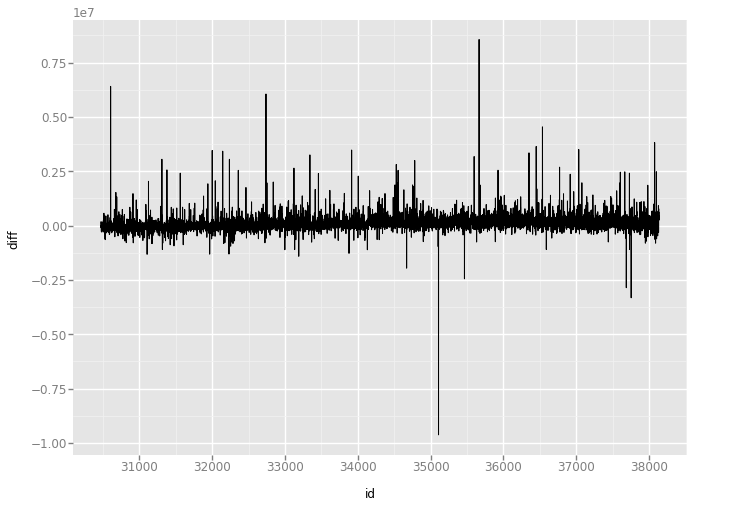

<ggplot: (8760012639436)>


In [93]:
print(g)

In [88]:
Current_Best = pd.read_csv('Log_Average_Best_Single_And_Gap_And_Area_Price.csv')

In [160]:
Second_Best = pd.read_csv('Log_Average_Best_Single_And_Gap.csv')

In [161]:
p0 = Second_Best['price_doc']

In [162]:
p0 = np.log1p(p0)

In [163]:
p5 = test_stacking['model5']
p1 = test_stacking['model1']
p3 = test_stacking['model3']

In [169]:
Average = np.exp(0.7*p0+0.1*p5+0.1*p3+0.1*p1)

In [170]:
Average

0       5.507304e+06
1       8.412690e+06
2       5.395804e+06
3       5.853802e+06
4       4.938654e+06
5       9.086583e+06
6       4.153339e+06
7       4.280447e+06
8       4.722215e+06
9       4.794963e+06
10      6.313202e+06
11      4.676831e+06
12      3.685463e+06
13      4.042210e+06
14      6.314864e+06
15      6.105799e+06
16      2.147008e+07
17      1.902543e+07
18      5.865122e+06
19      1.334586e+07
20      7.006402e+06
21      1.023154e+07
22      8.412383e+06
23      8.497570e+06
24      4.677978e+06
25      8.263655e+06
26      1.103720e+07
27      7.102243e+06
28      3.005682e+06
29      6.656188e+06
            ...     
7632    6.110307e+06
7633    3.156704e+06
7634    1.032901e+07
7635    5.249379e+06
7636    4.354740e+06
7637    4.771488e+06
7638    3.628690e+06
7639    6.990893e+06
7640    7.894706e+06
7641    3.480989e+06
7642    6.890199e+06
7643    6.416098e+06
7644    6.867485e+06
7645    3.394081e+06
7646    6.582621e+06
7647    4.917296e+06
7648    6.613

In [171]:
sub = pd.DataFrame({'id':test['id'],'price_doc':Average})

In [172]:
sub.to_csv('Final_Submit_015320160630Finallllllllllll.csv',index=False)

In [ ]:
pd.DataFrame({'model1':np.log1p(model1_test['price_doc']),'model2':np.log1p(model23_test['Price_SQM']),'model3':np.log1p(model23_test['Price_Gap']),'model4':np.log1p(Best_Stack_Output)})